# Depict Performances as Box-Whisker Plots and Comprehensive Heatmaps

<hr/>

#### Imports

In [1]:
import collections

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#### Constants

In [2]:
DATA_FOLDER = '../../../data/generated_by_notebooks/'
PLOT_FOLDER = './plots/box_whisker/'

#### Settings

In [3]:
mpl.rcParams['figure.dpi'] = 200

algorithms = ['rf', 'xgb', 'svm_rbf', 'shallow', 'dropout']
algorithm_names = ['RF', 'XGB', 'SVM', 'Shallow', 'Deep']
algorithm_to_name = dict(zip(algorithms, algorithm_names))

descriptors = ['maccs', 'ecfc', 'rdkit', 'cddd']
descriptor_names = ['MACCS', 'ECFC', 'RDKit', 'CDDD']
descriptor_to_name = dict(zip(descriptors, descriptor_names))

# Names of the datasets that were already run
dataset_names = [
    'tetrahymena',
    'freesolv',
    'esol',
    'MMP2',
    'IL4',
    'F7',
    'O60674',
    'O14965',
    'P03372',
    'P04150',
    'P06401',
    'P11229',
    'P12931',
    'P16581',
    'P17252',
    'P18089',
    'P19327',
    'P21554',
    'P24530',
    'P25929',
    'P28335',
    'P28482',
    'P35968',
    'P41594',
    'P42345',
    'P47871',
    'P49146',
    'P61169',
    'Q05397',
    'Q16602',
    'P24941',
    'Q92731'
]

#### Functions

In [4]:
def load_evaluation_matrix(name, evaluation='predictive', to_matrix=True):
    """Loads performance table for a single dataset."""
    path = f'{DATA_FOLDER}/{evaluation}_performances/{name}.csv'
    df = pd.read_csv(path, sep=';').set_index('descriptor')
    if to_matrix:
        matrix = df.to_numpy()
        return matrix
    else:
        return df
    
    
def fetch(performance_dfs, labels, transpose=False):
    """Collects performance values from a list of dataframes, where 'labels' are the column names."""
    collected = [pd.DataFrame() for _ in range(len(labels))]
    for dataset_name in dataset_names:
        df = performance_dfs[dataset_name]
        if transpose:
            df = df.T
        for i, label in enumerate(labels):
            collected[i][dataset_name] = df[label]
    return collected


def make_y_range(yrange, interval=.1):
    """Creates a range between yrange[0] and yrange[1] with a given interval."""
    factor = 1./interval
    ylow = int(factor * yrange[0])
    yhigh = int(factor * yrange[1])
    rang = range(ylow, yhigh+1)
    rang_adjusted = [np.round(val*interval, 1) for val in rang]
    return rang_adjusted
    
    
def bw_plot(data, data_xlabels, data_ylabels, yrange=(-.2, 1.), ylabel='$R^2$', image_path=None, texts=None, text_locs=None):
    """Creates a box-whisker plot."""
    fix, axes = plt.subplots(1, len(data_xlabels), figsize=(20, 6))
    for i in range(len(axes)):
        ax = axes[i]
        df = data[i]
        title = data_xlabels[i]
        ax.grid(zorder=1000)
        for j, column in enumerate(df.T.columns):
            flierprops = {'markerfacecolor':f'C{j}', 'markeredgecolor':f'C{j}', 'alpha':.5}
            box = ax.boxplot(df.T[column], flierprops=flierprops, positions=[j], widths=[.5], patch_artist=True)
            for k, patch in enumerate(box['boxes']):
                patch.set_facecolor(f'C{j}')
                patch.set_edgecolor(f'C{j}')
                patch.set_alpha(.5)
            for patch in box['medians']:
                patch.set_color(f'C{j}')
                patch.set_linewidth(1.5)
            for item in ['whiskers', 'fliers', 'caps']:
                for patch in box[item]:
                    patch.set_color(f'C{j}')
                    patch.set_linewidth(1.5)
        ax.set_ylim(yrange)
        ax.set_title(title, size=15)
        ax.set_xticks(range(len(data_ylabels)))
        ax.set_xticklabels(data_ylabels)
        rang_adjusted = make_y_range(yrange)
        ax.set_yticks(rang_adjusted)
        ax.set_yticklabels(rang_adjusted)
        plt.setp(ax.xaxis.get_majorticklabels(), size=12)
        plt.setp(ax.yaxis.get_majorticklabels(), size=12)
        if texts:
            if text_locs:
                ax.text(text_locs[0], text_locs[1], texts[i], fontsize=20, weight='bold')
            else:
                ax.text(-.4, .62, texts[i], fontsize=20, weight='bold')
        if i == 0:
            ax.set_ylabel(ylabel, size=12)
    if image_path:
        plt.savefig(image_path, bbox_inches='tight', pad_inches=0.05)
    plt.show()
    
    
def heatmap(values_df, vmax=1., vmin=.0, image_path=None):
    """Plots a customized heatmap."""
    # Prepare data
    pred_for_supp = pd.DataFrame(index=values_df.T.index)
    for i, col in enumerate(values_df.T.columns):
        if i % 4 == 0 and i > 0:
            pred_for_supp[f'gap_after_{i}'] = [np.nan for _ in range(len(values_df.T))]
        pred_for_supp[col] = values_df.T[col]
    pred_for_supp_rf = pred_for_supp[['MACCS+RF', 'MFC+RF', 'RDKit+RF', 'CDDD+RF']]
    pred_for_supp_xgb = pred_for_supp[['MACCS+XGB', 'MFC+XGB', 'RDKit+XGB', 'CDDD+XGB']]
    pred_for_supp_svm = pred_for_supp[['MACCS+SVM', 'MFC+SVM', 'RDKit+SVM', 'CDDD+SVM']]
    pred_for_supp_shallow = pred_for_supp[['MACCS+Shallow', 'MFC+Shallow', 'RDKit+Shallow', 'CDDD+Shallow']]
    pred_for_supp_deep = pred_for_supp[['MACCS+Deep', 'MFC+Deep', 'RDKit+Deep', 'CDDD+Deep']]
    preds_collection = [pred_for_supp_rf, pred_for_supp_xgb, pred_for_supp_svm, pred_for_supp_shallow, pred_for_supp_deep]
    # Plot
    fig, axes = plt.subplots(1, 5, figsize=(15, 20), sharey=False)
    for i, (ax, preds_subdf) in enumerate(zip(axes, preds_collection)):
        sns.heatmap(preds_subdf, yticklabels=1, cmap='viridis', annot=True, annot_kws={'size': 12}, cbar=False, vmax=vmax, vmin=vmin, ax=ax)
        ax.set_title(algorithm_names[i])
        ax.tick_params(labelbottom=False, bottom=False, top=True, labeltop=True)
        custom_ticks = np.array(range(len(descriptor_names))) + .5
        ax.set_xticks(custom_ticks)
        ax.set_xticklabels(descriptor_names)
        if i == 0:
            ax.set_yticklabels([get_dataset_name_correct(col) for col in preds_subdf.T.columns])
        else:
            ax.set_yticks([])
    plt.subplots_adjust(wspace=.0125)
    if image_path:
        plt.savefig(image_path, bbox_inches='tight', pad_inches=0.05)
    plt.show()
    
    
def get_dataset_name_correct(name):
    """Formats a dataset name."""
    if name == 'tetrahymena':
        return 'Tetrahymena'
    elif name == 'freesolv':
        return 'FreeSolv'
    elif name == 'esol':
        return 'ESOL'
    else:
        return name

<hr/>

#### Load data

In [5]:
predictive_performances = dict()
uncertainty_performances = dict()

for dataset_name in dataset_names:
    pred_df = load_evaluation_matrix(dataset_name, evaluation='predictive', to_matrix=False)
    predictive_performances[dataset_name] = pred_df
    uq_df = load_evaluation_matrix(dataset_name, evaluation='uncertainty', to_matrix=False)
    uncertainty_performances[dataset_name] = uq_df

#### Prepare

In [6]:
pred_algorithm_wise = fetch(predictive_performances, algorithm_names)
pred_descriptor_wise = fetch(predictive_performances, descriptor_names, transpose=True)

uq_algorithm_wise = fetch(uncertainty_performances, algorithm_names)
uq_descriptor_wise = fetch(uncertainty_performances, descriptor_names, transpose=True)

<hr/>

### Plot Predictive Performances

Algorithm-wise

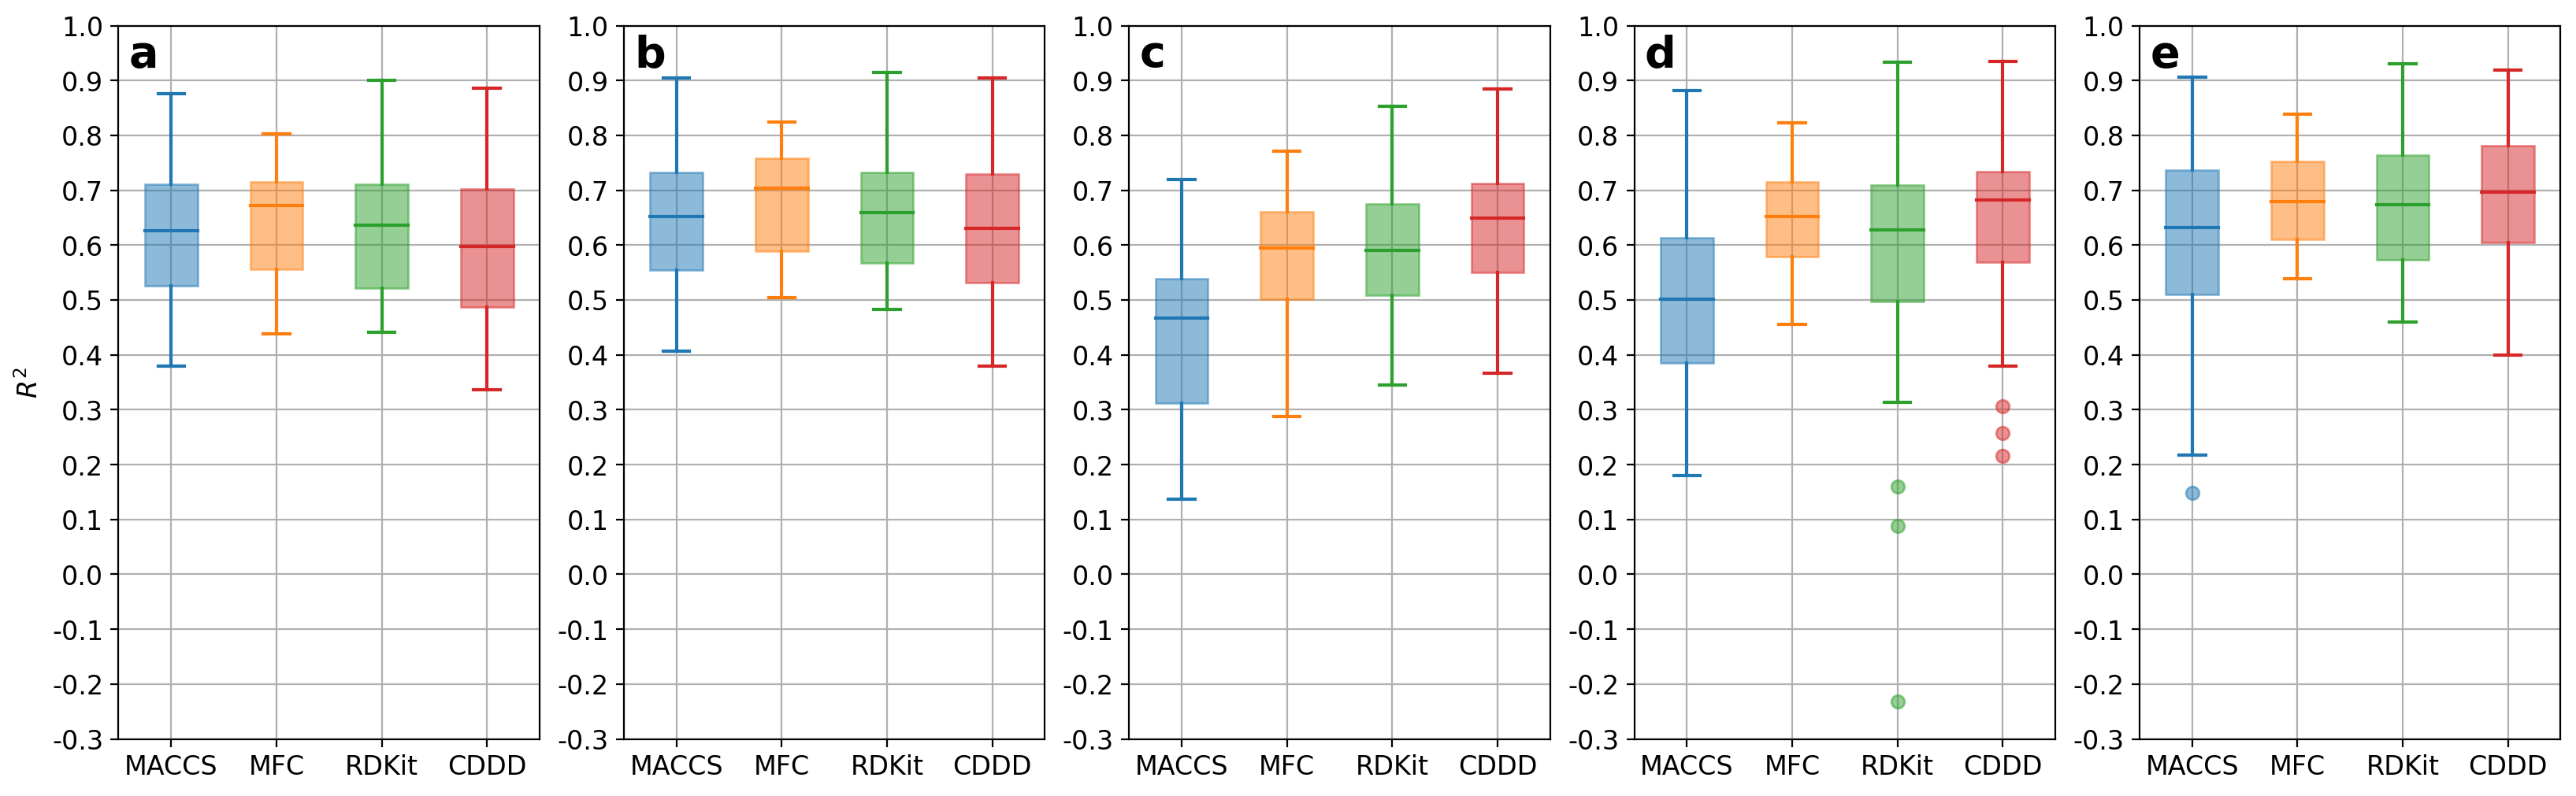

In [7]:
bw_plot(
    pred_algorithm_wise,
    ['', '', '', '', ''],
    ['MACCS', 'MFC', 'RDKit', 'CDDD'],
    yrange=(-.3, 1.),
    image_path=PLOT_FOLDER+'pred_for_algorithms.pdf',
    texts=['a', 'b', 'c', 'd', 'e'],
    text_locs=[-.4, .925]
)

Descriptor-wise

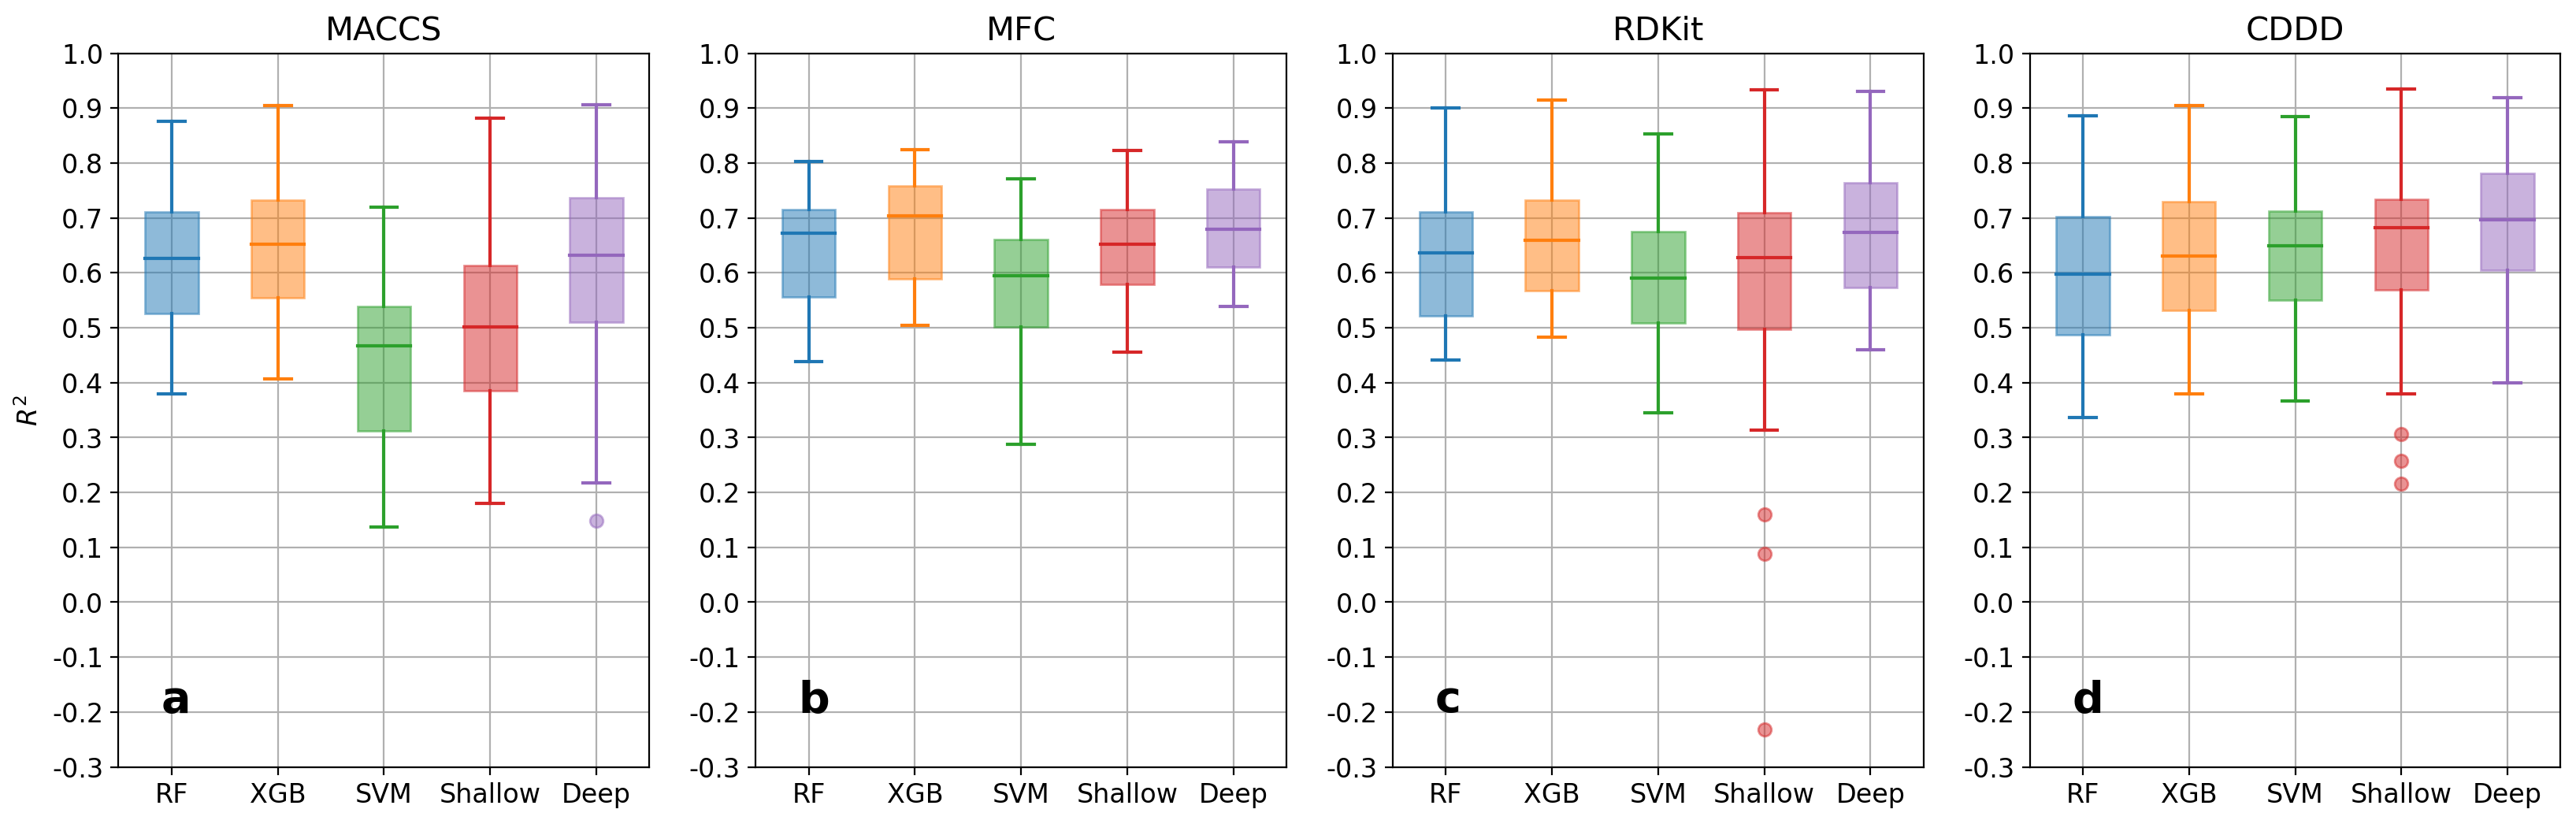

In [8]:
bw_plot(
    pred_descriptor_wise,
    ['MACCS', 'MFC', 'RDKit', 'CDDD'],
    algorithm_names,
    yrange=(-.3, 1.),
    image_path=PLOT_FOLDER+'pred_for_descriptors.pdf',
    texts=['a', 'b', 'c', 'd'],
    text_locs=[-.1, -.2]
)

### Plot Uncertainty Performances

Algorithm-wise

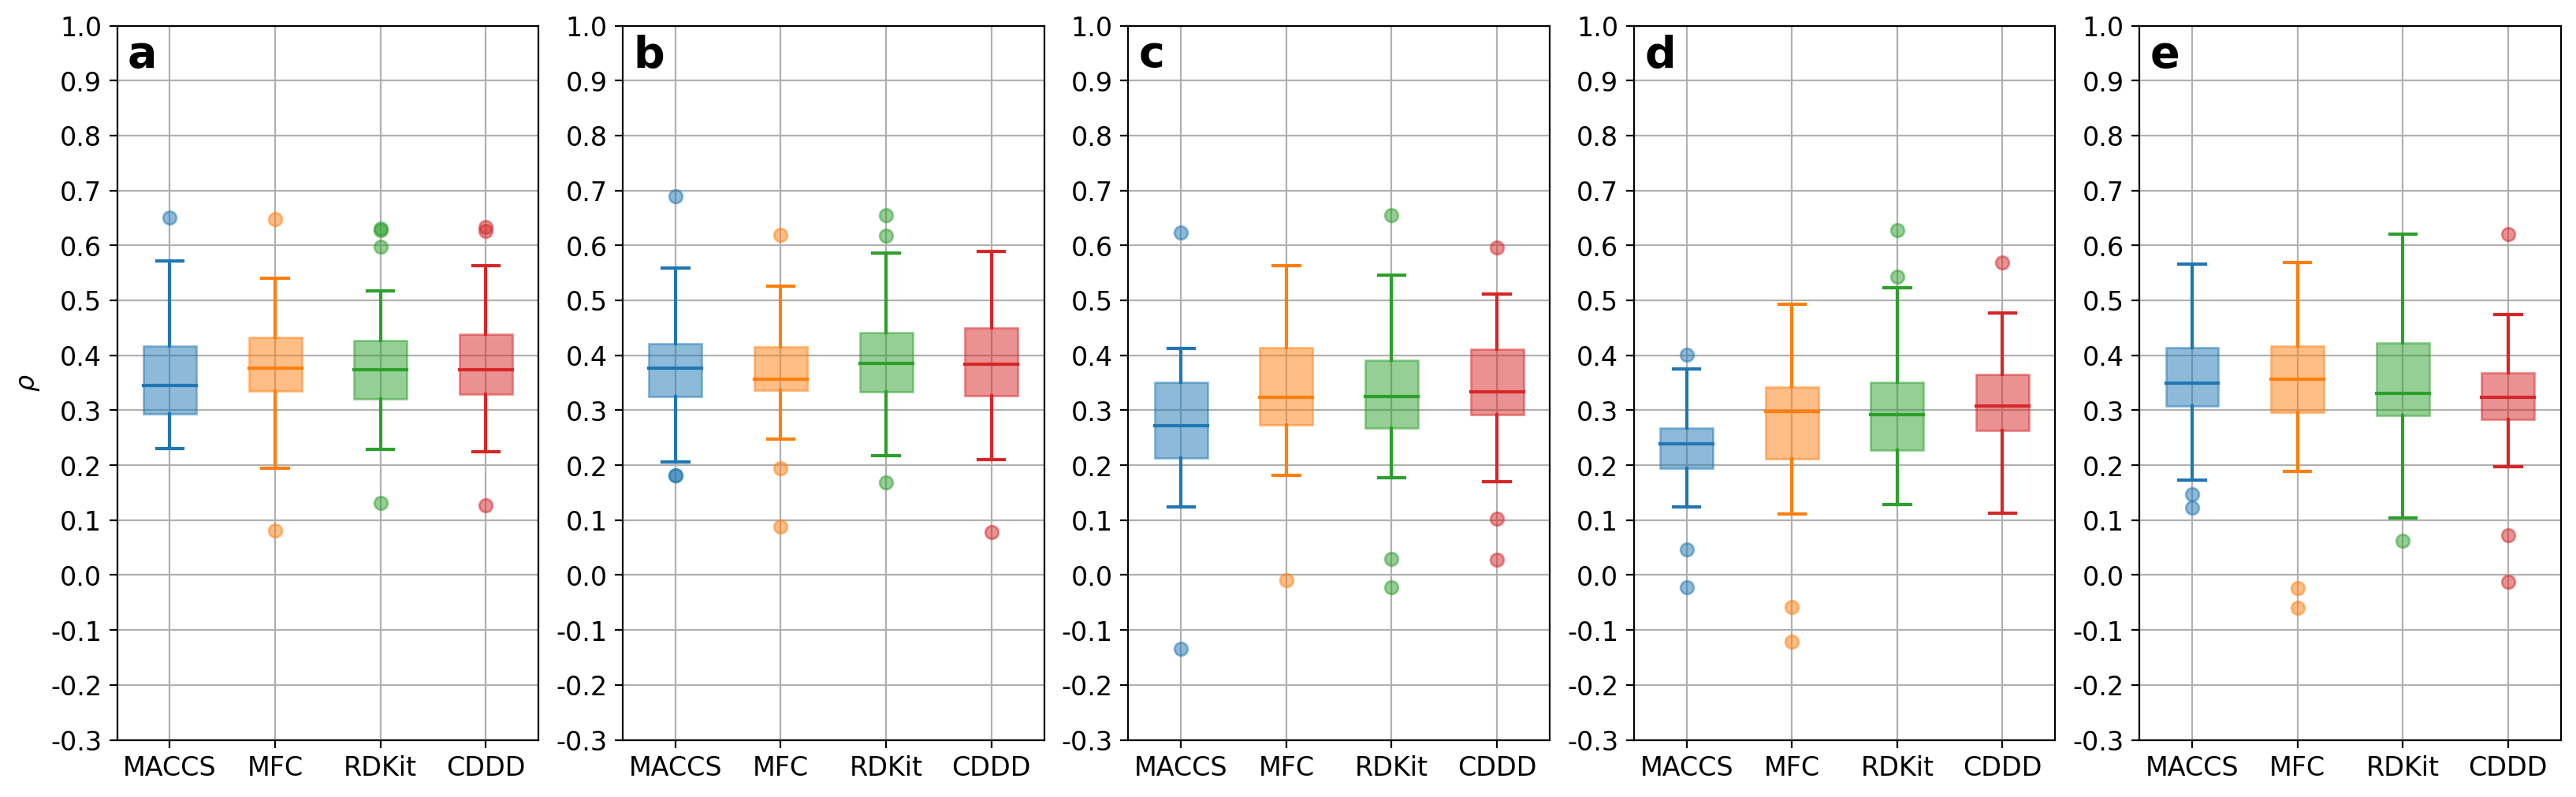

In [9]:
bw_plot(
    uq_algorithm_wise,
    ['', '', '', '', ''],
    ['MACCS', 'MFC', 'RDKit', 'CDDD'],
    yrange=[-.3, 1.],
    ylabel=r'$\rho$',
    image_path=PLOT_FOLDER+'uq_for_algorithms.pdf',
    texts=['a', 'b', 'c', 'd', 'e'],
    text_locs=[-.4, .925]
)

Descriptor-wise

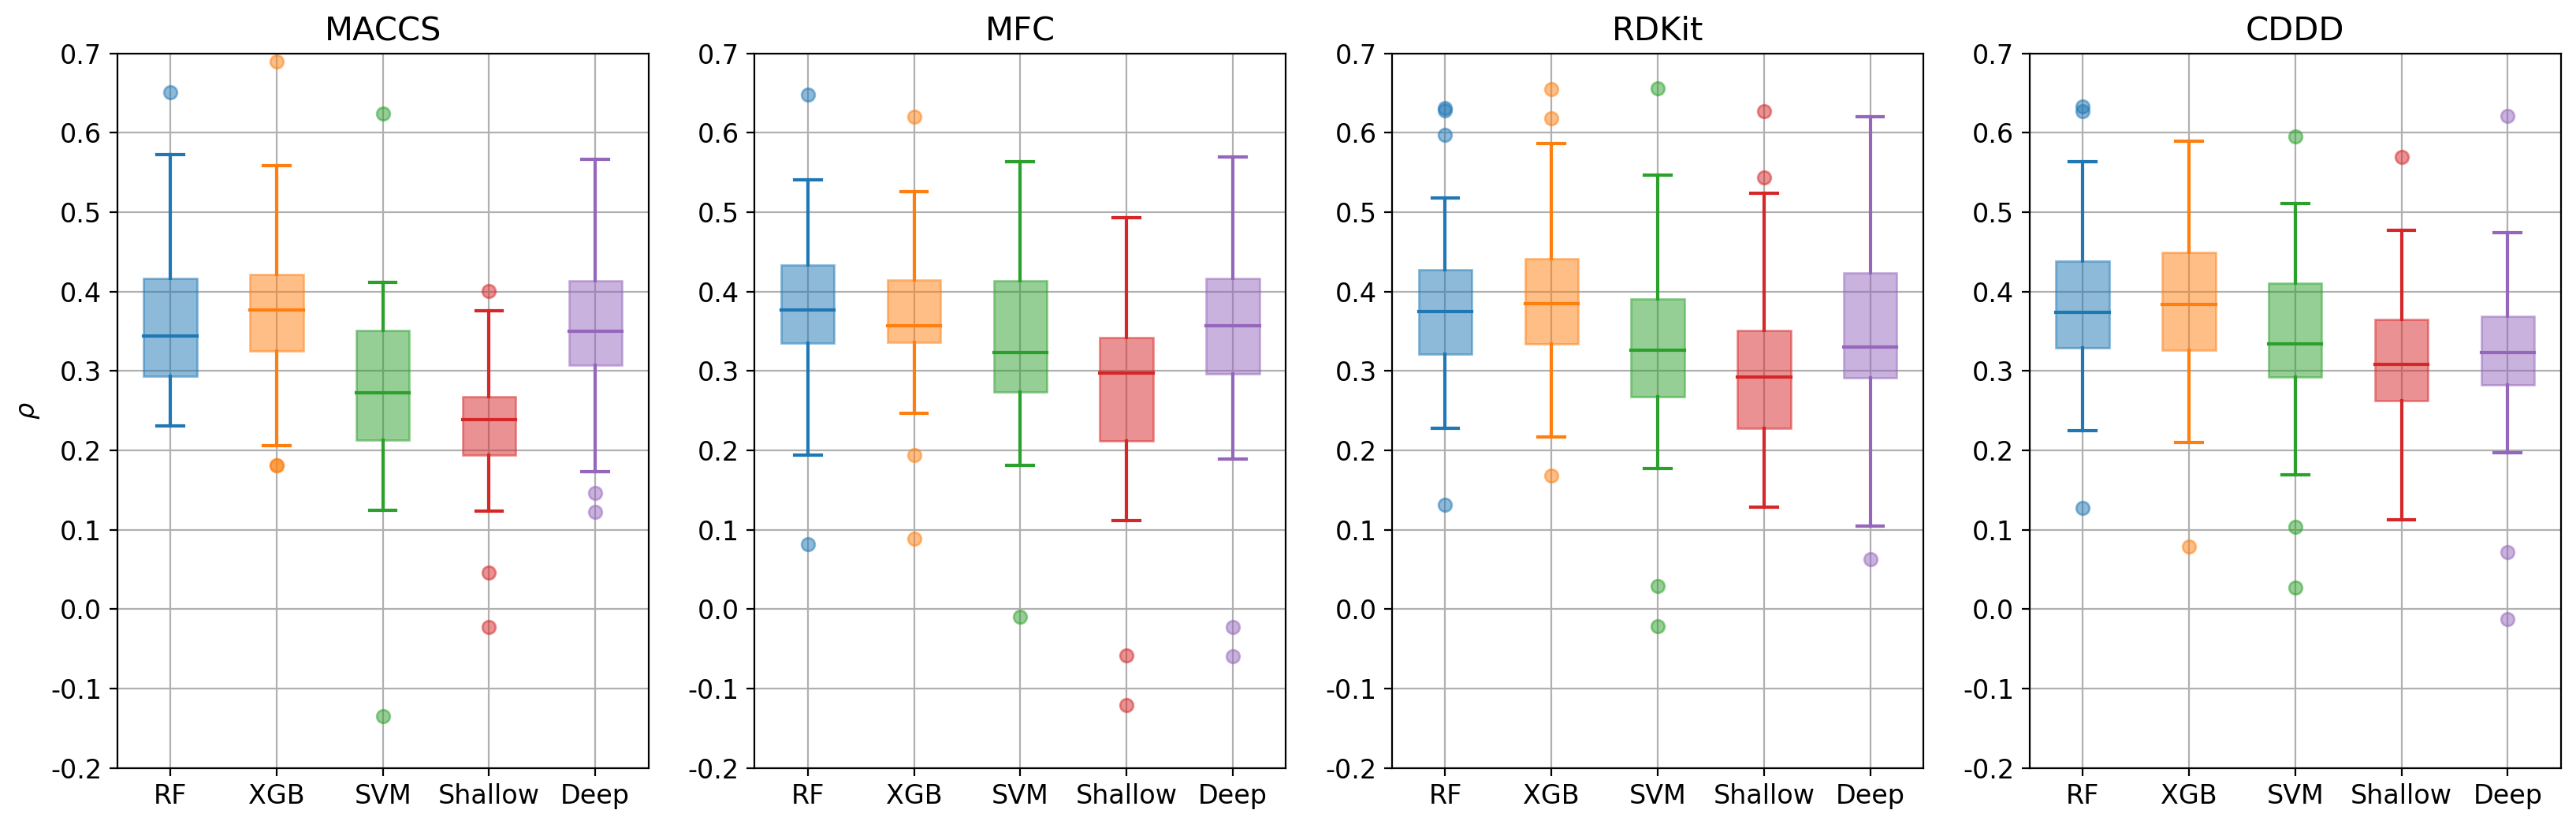

In [10]:
bw_plot(
    uq_descriptor_wise,
    ['MACCS', 'MFC', 'RDKit', 'CDDD'],
    algorithm_names,
    yrange=[-.2, .7],
    ylabel=r'$\rho$',
    image_path=PLOT_FOLDER+'uq_for_descriptors.pdf'
)

#### Visualize all Results in a Heatmap

Collect

In [11]:
for i, algo in enumerate(algorithm_names):
    algo_list = [algo for _ in range(len(uq_algorithm_wise[i]))]
    uq_algorithm_wise[i]['algorithm'] = algo_list
    pred_algorithm_wise[i]['algorithm'] = algo_list
    
uq_algorithm_wise_all = pd.concat(uq_algorithm_wise).reset_index()
pred_algorithm_wise_all = pd.concat(pred_algorithm_wise).reset_index()

uq_algorithm_wise_all.replace('ECFC', 'MFC', inplace=True)
pred_algorithm_wise_all.replace('ECFC', 'MFC', inplace=True)

combi_names = [f'{desc}+{ml}' for desc, ml in zip(uq_algorithm_wise_all['descriptor'], uq_algorithm_wise_all['algorithm'])]
uq_algorithm_wise_all['combination'] = combi_names
pred_algorithm_wise_all['combination'] = combi_names

uq_algorithm_wise_all_new_id = uq_algorithm_wise_all.set_index('combination')
uq_algorithm_wise_all_new_id.drop(columns=['descriptor', 'algorithm'], inplace=True)
pred_algorithm_wise_all_new_id = pred_algorithm_wise_all.set_index('combination')
pred_algorithm_wise_all_new_id.drop(columns=['descriptor', 'algorithm'], inplace=True)

Plot predictive

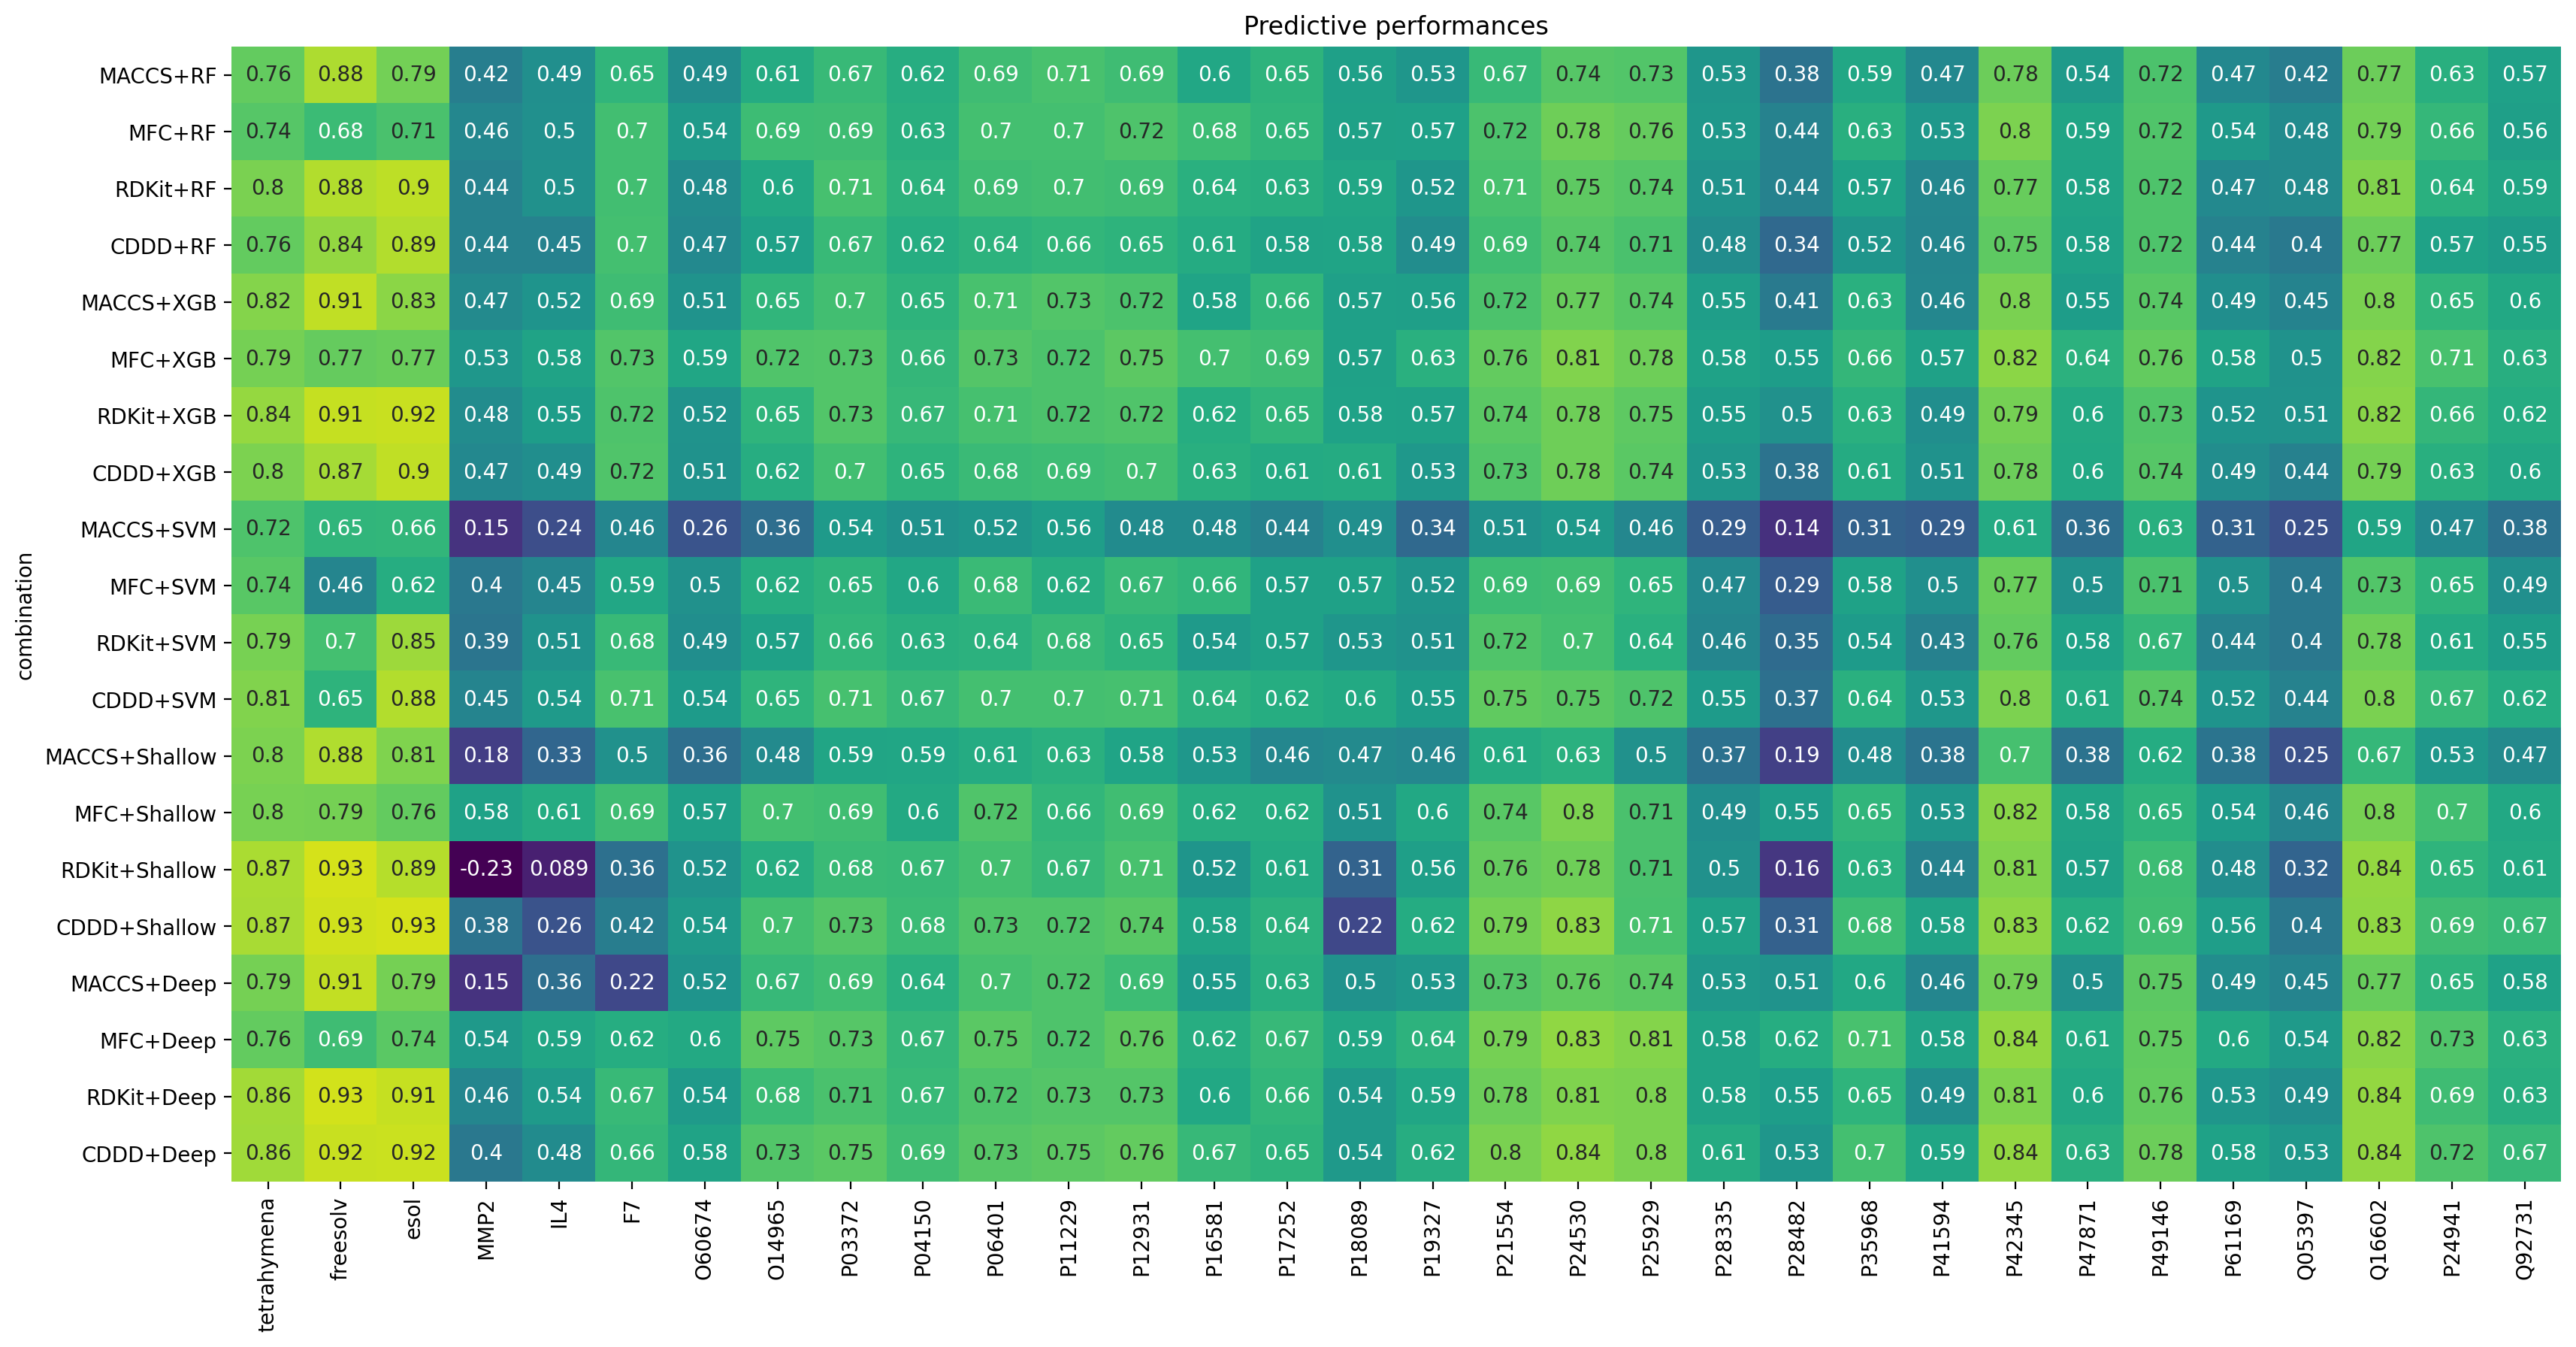

In [12]:
plt.figure(figsize=(20, 10))
plt.title('Predictive performances')
sns.heatmap(pred_algorithm_wise_all_new_id, xticklabels=1, cmap='viridis', annot=True, annot_kws={'size': 10}, cbar=False, vmax=1., vmin=.0)
plt.show()

Plot for Supporting Information

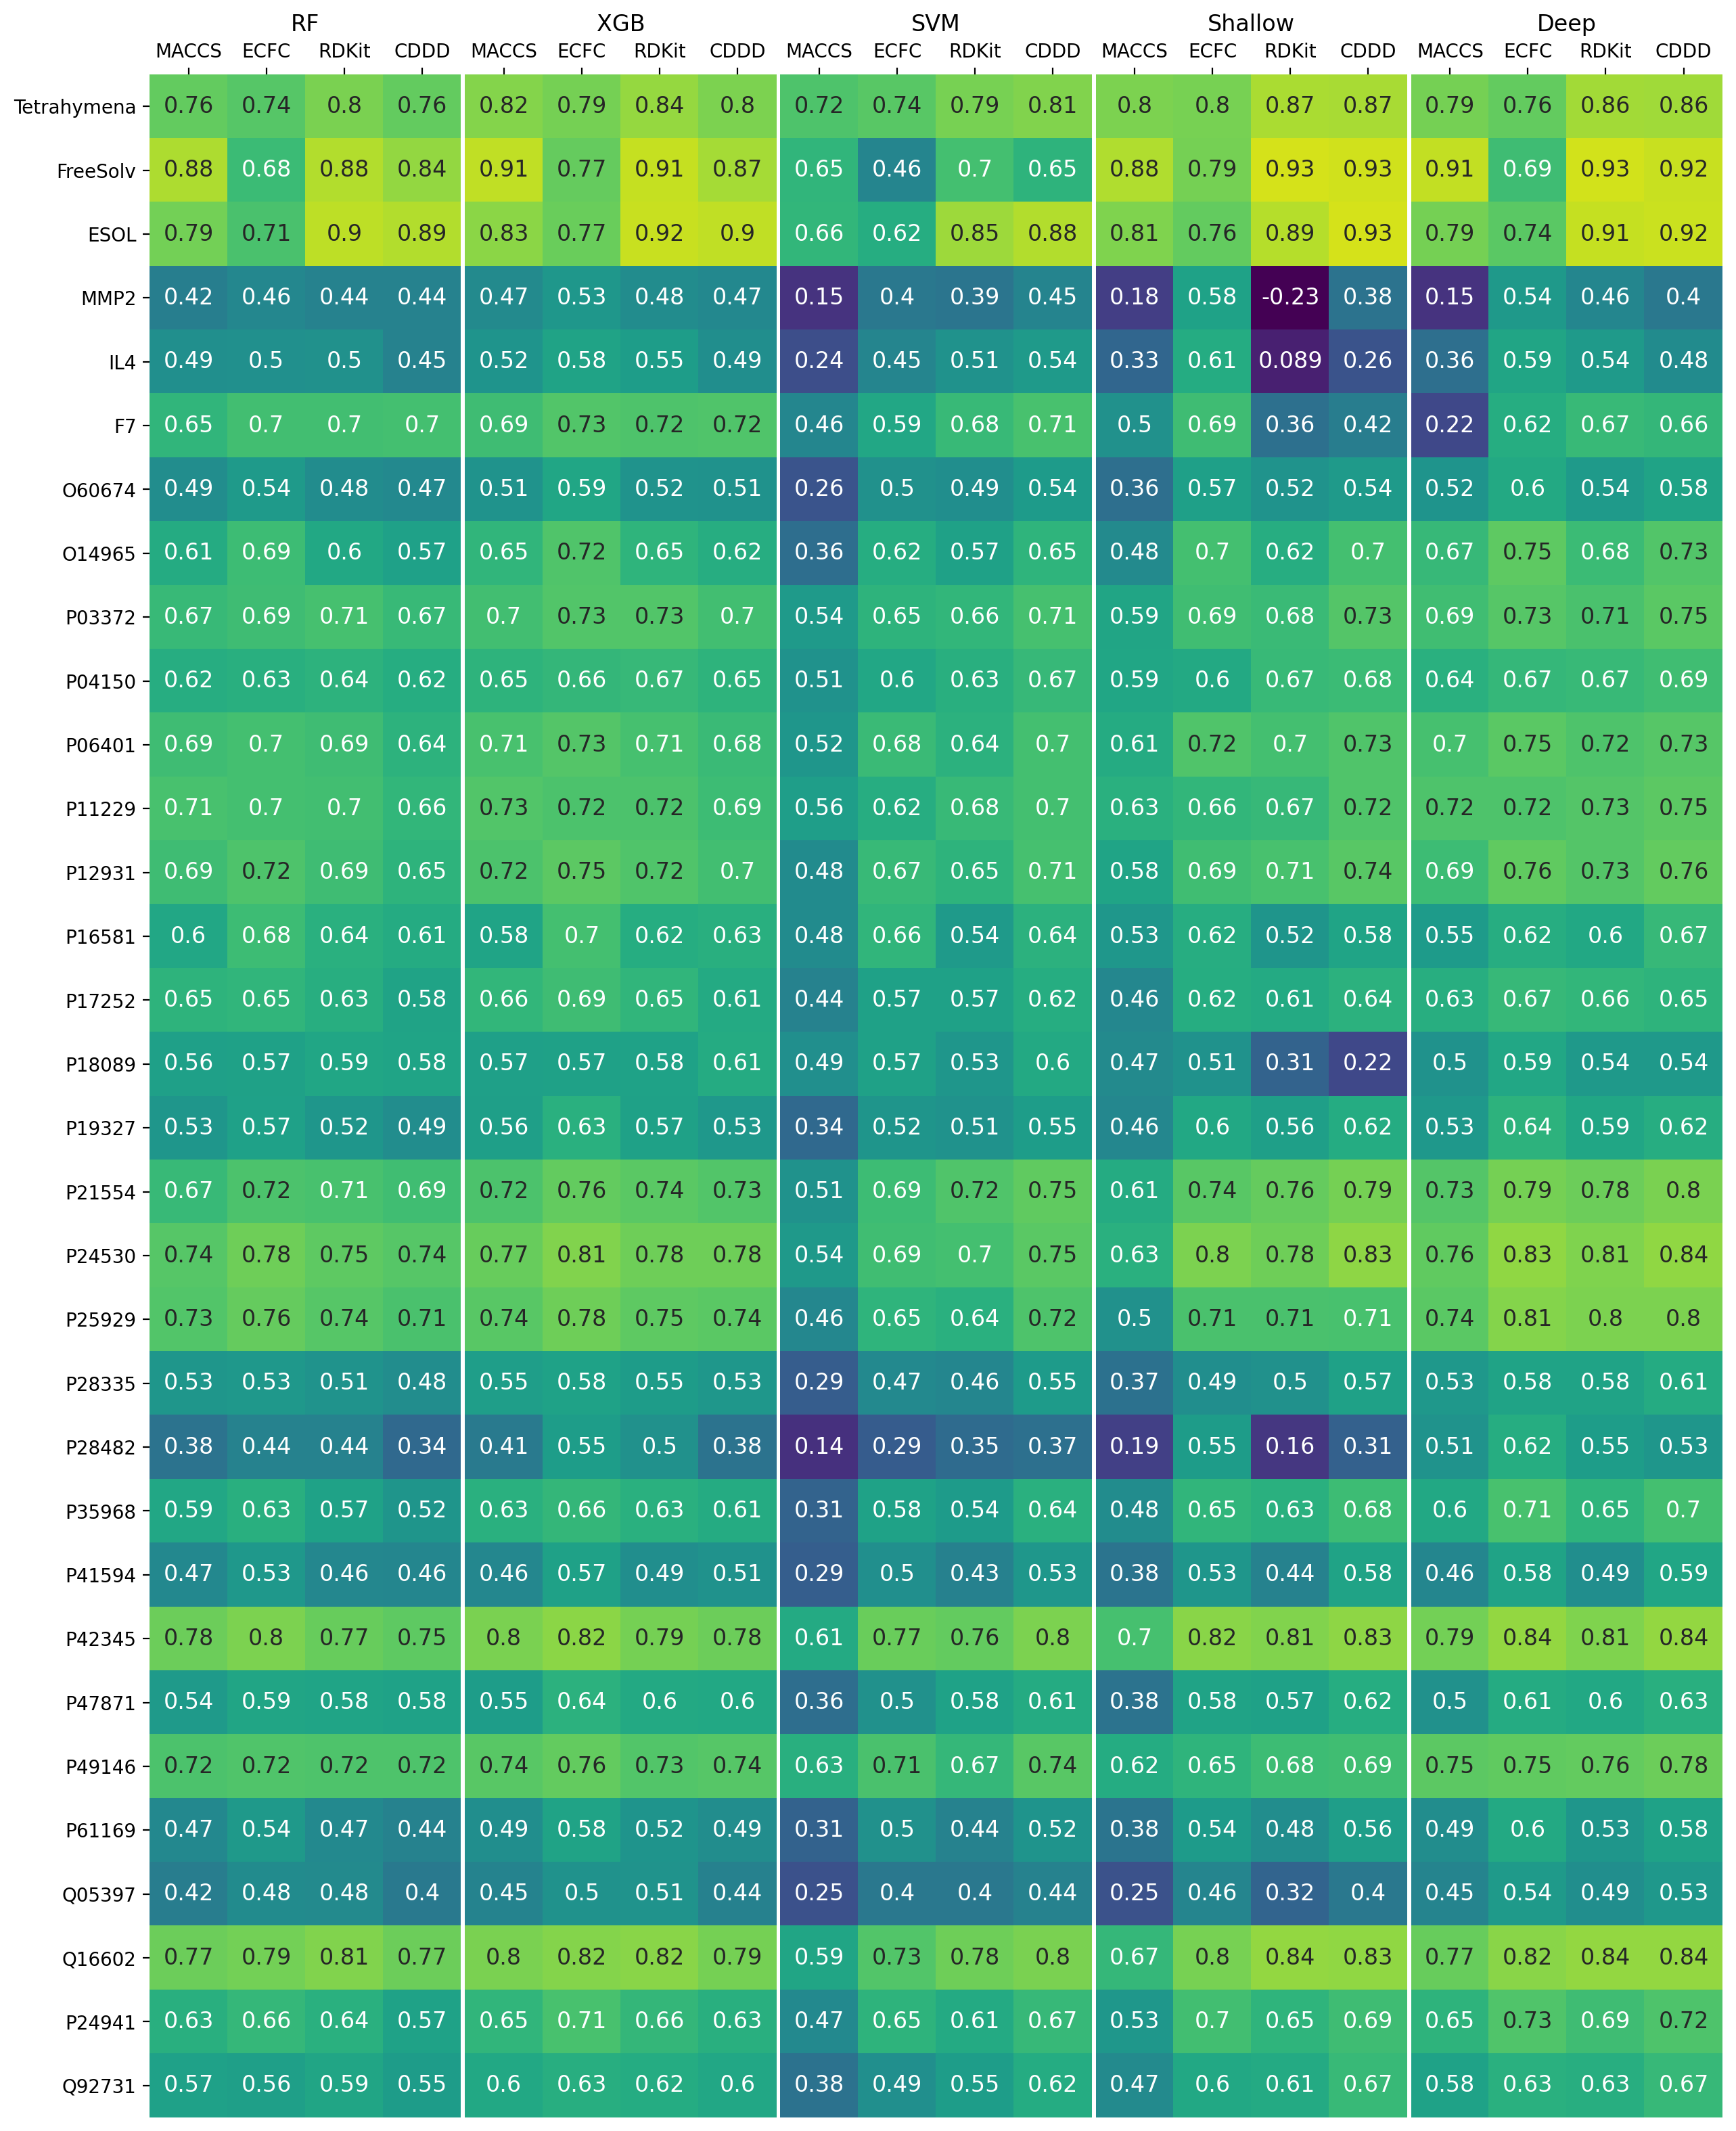

In [13]:
heatmap(pred_algorithm_wise_all_new_id, image_path='./plots/complete_heatmaps/pred_heat.pdf')

Find those datasets with biggest $R^2$ difference

In [14]:
(pred_algorithm_wise_all_new_id.max() - pred_algorithm_wise_all_new_id.abs().min()).sort_values(ascending=False).head()

IL4         0.525142
F7          0.510008
P28482      0.480801
freesolv    0.477184
MMP2        0.430849
dtype: float64

Find largest $R^2$ in every set

In [15]:
pred_algorithm_wise_all_new_id.max().sort_values()

Q05397         0.539262
MMP2           0.577507
P41594         0.592692
O60674         0.602900
P61169         0.604832
P28335         0.609736
P18089         0.610868
IL4            0.613949
P28482         0.617577
P47871         0.639360
P19327         0.641820
Q92731         0.672932
P17252         0.688168
P04150         0.692279
P16581         0.701181
P35968         0.708456
P24941         0.725253
F7             0.727850
P03372         0.745061
P06401         0.745682
P11229         0.748168
O14965         0.750945
P12931         0.759016
P49146         0.775235
P21554         0.798796
P25929         0.813187
P24530         0.835641
P42345         0.838096
Q16602         0.838995
tetrahymena    0.871720
freesolv       0.933962
esol           0.934726
dtype: float64

Plot uncertainty

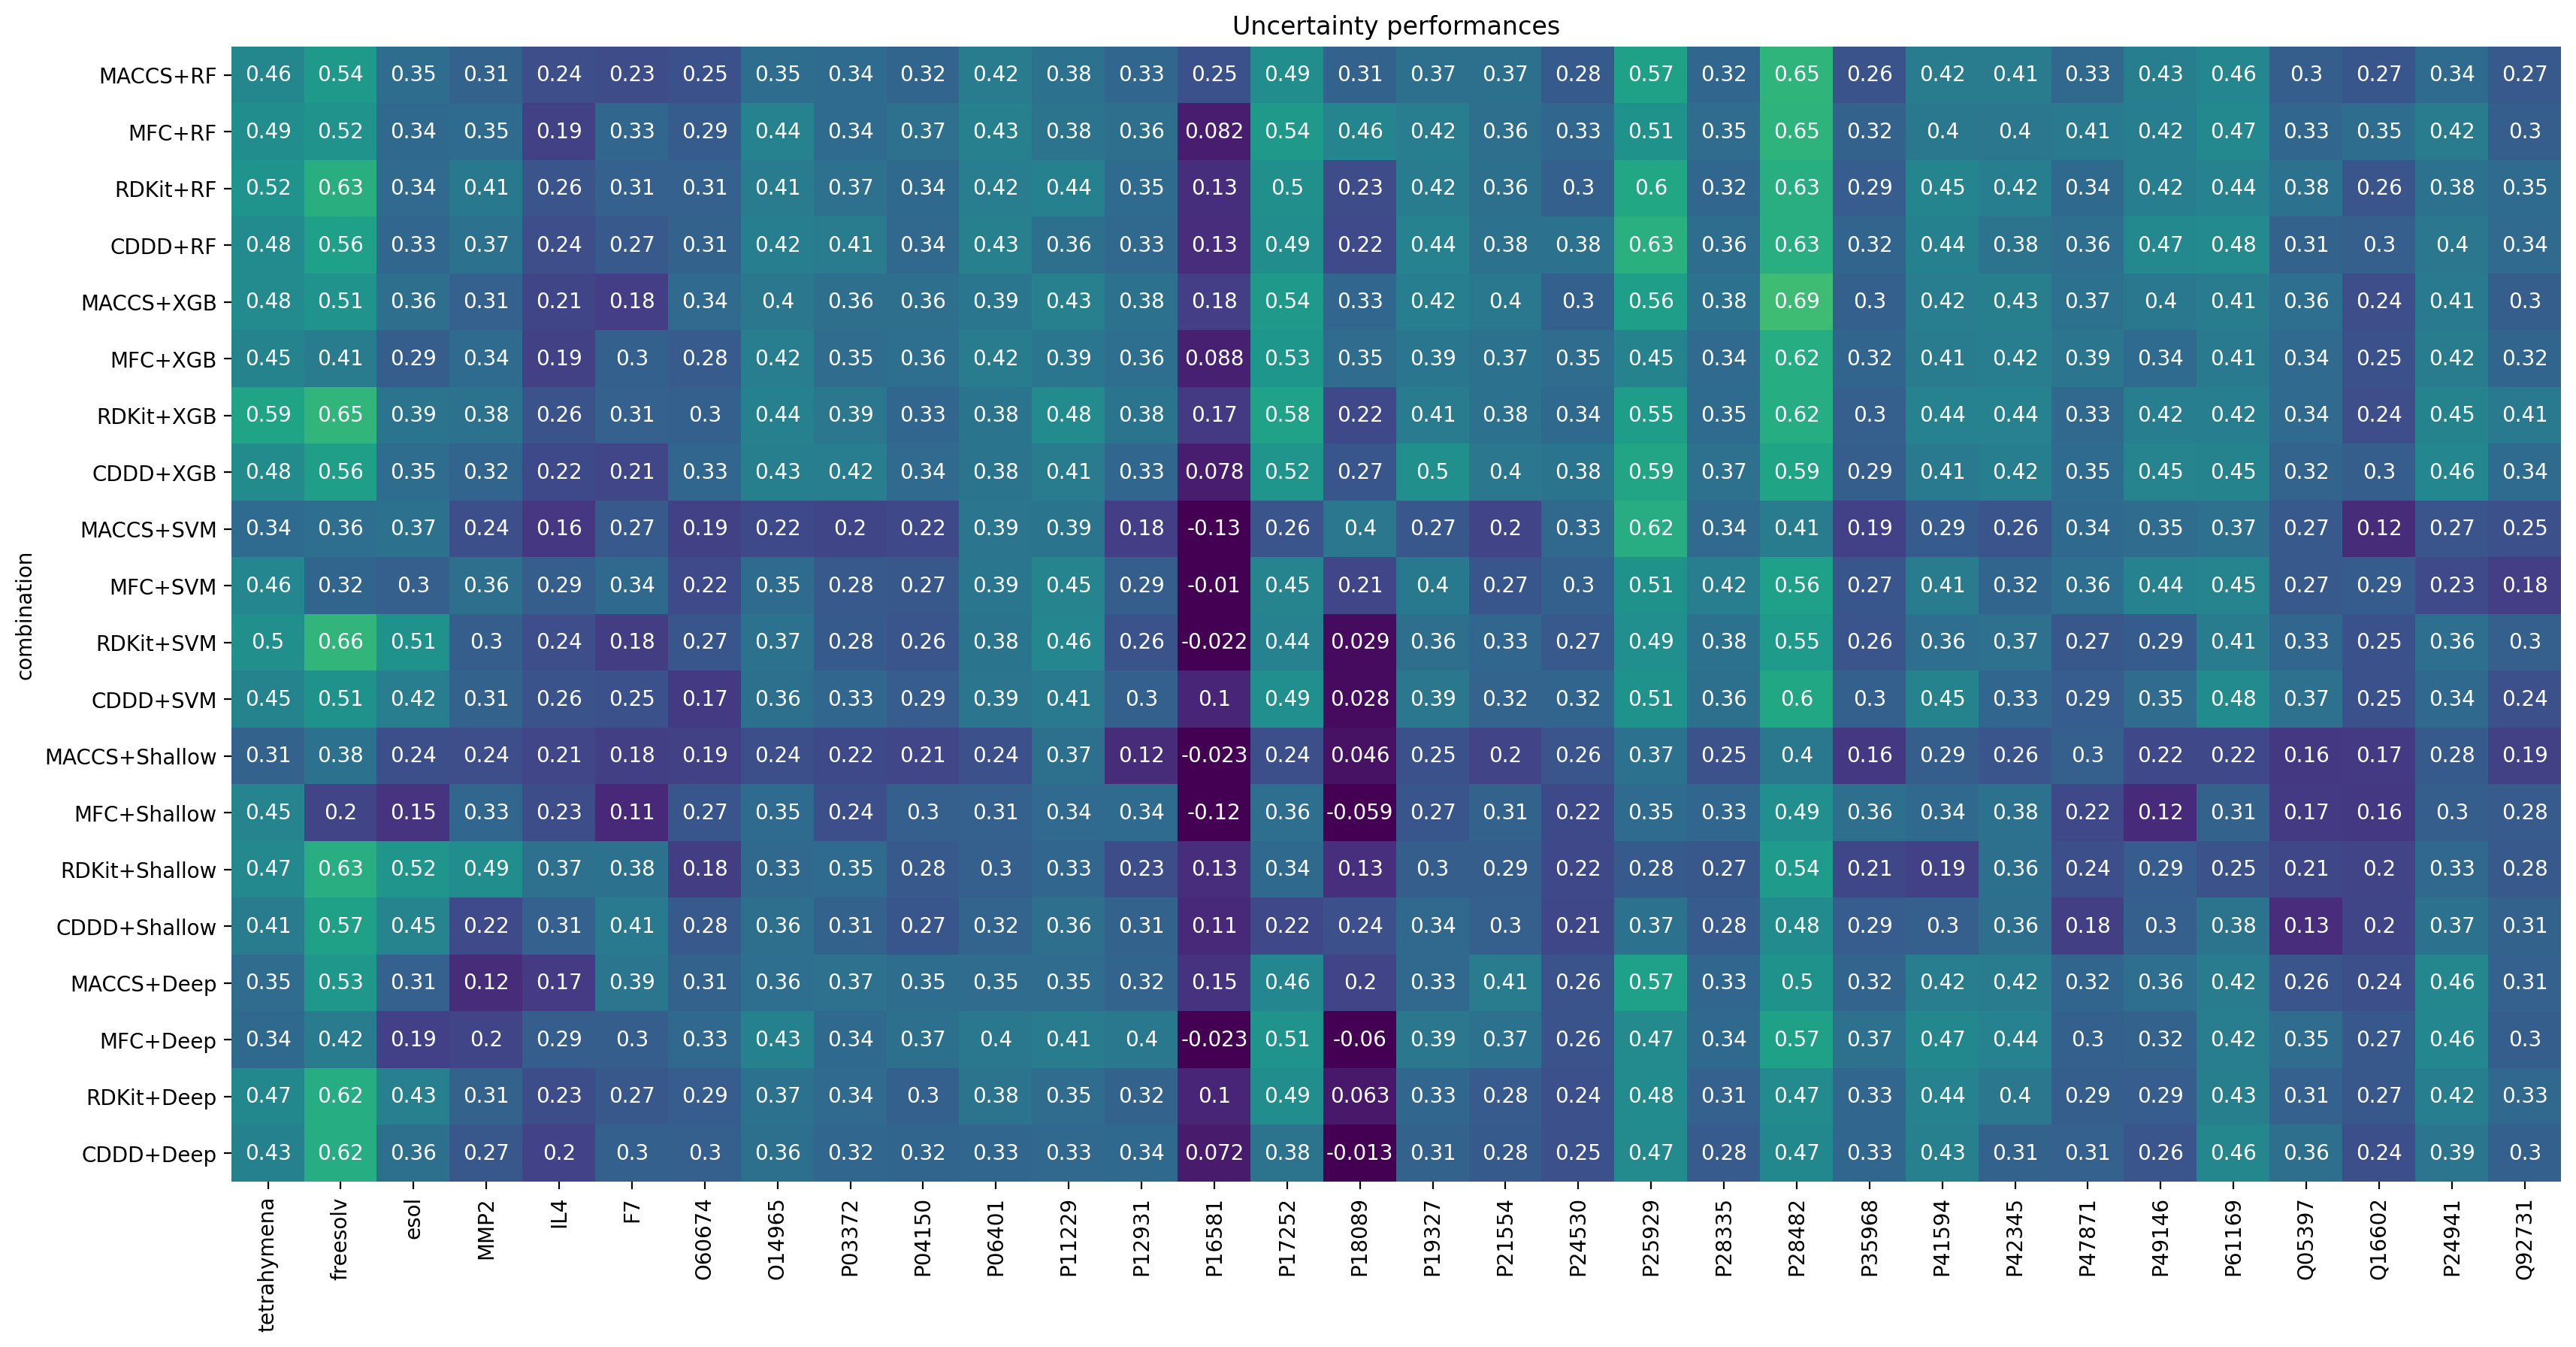

In [16]:
plt.figure(figsize=(20, 10))
plt.title('Uncertainty performances')
sns.heatmap(uq_algorithm_wise_all_new_id, xticklabels=1, cmap='viridis', annot=True, annot_kws={'size': 10}, cbar=False, vmax=1., vmin=.0)
plt.show()

Plot for Supporting Information

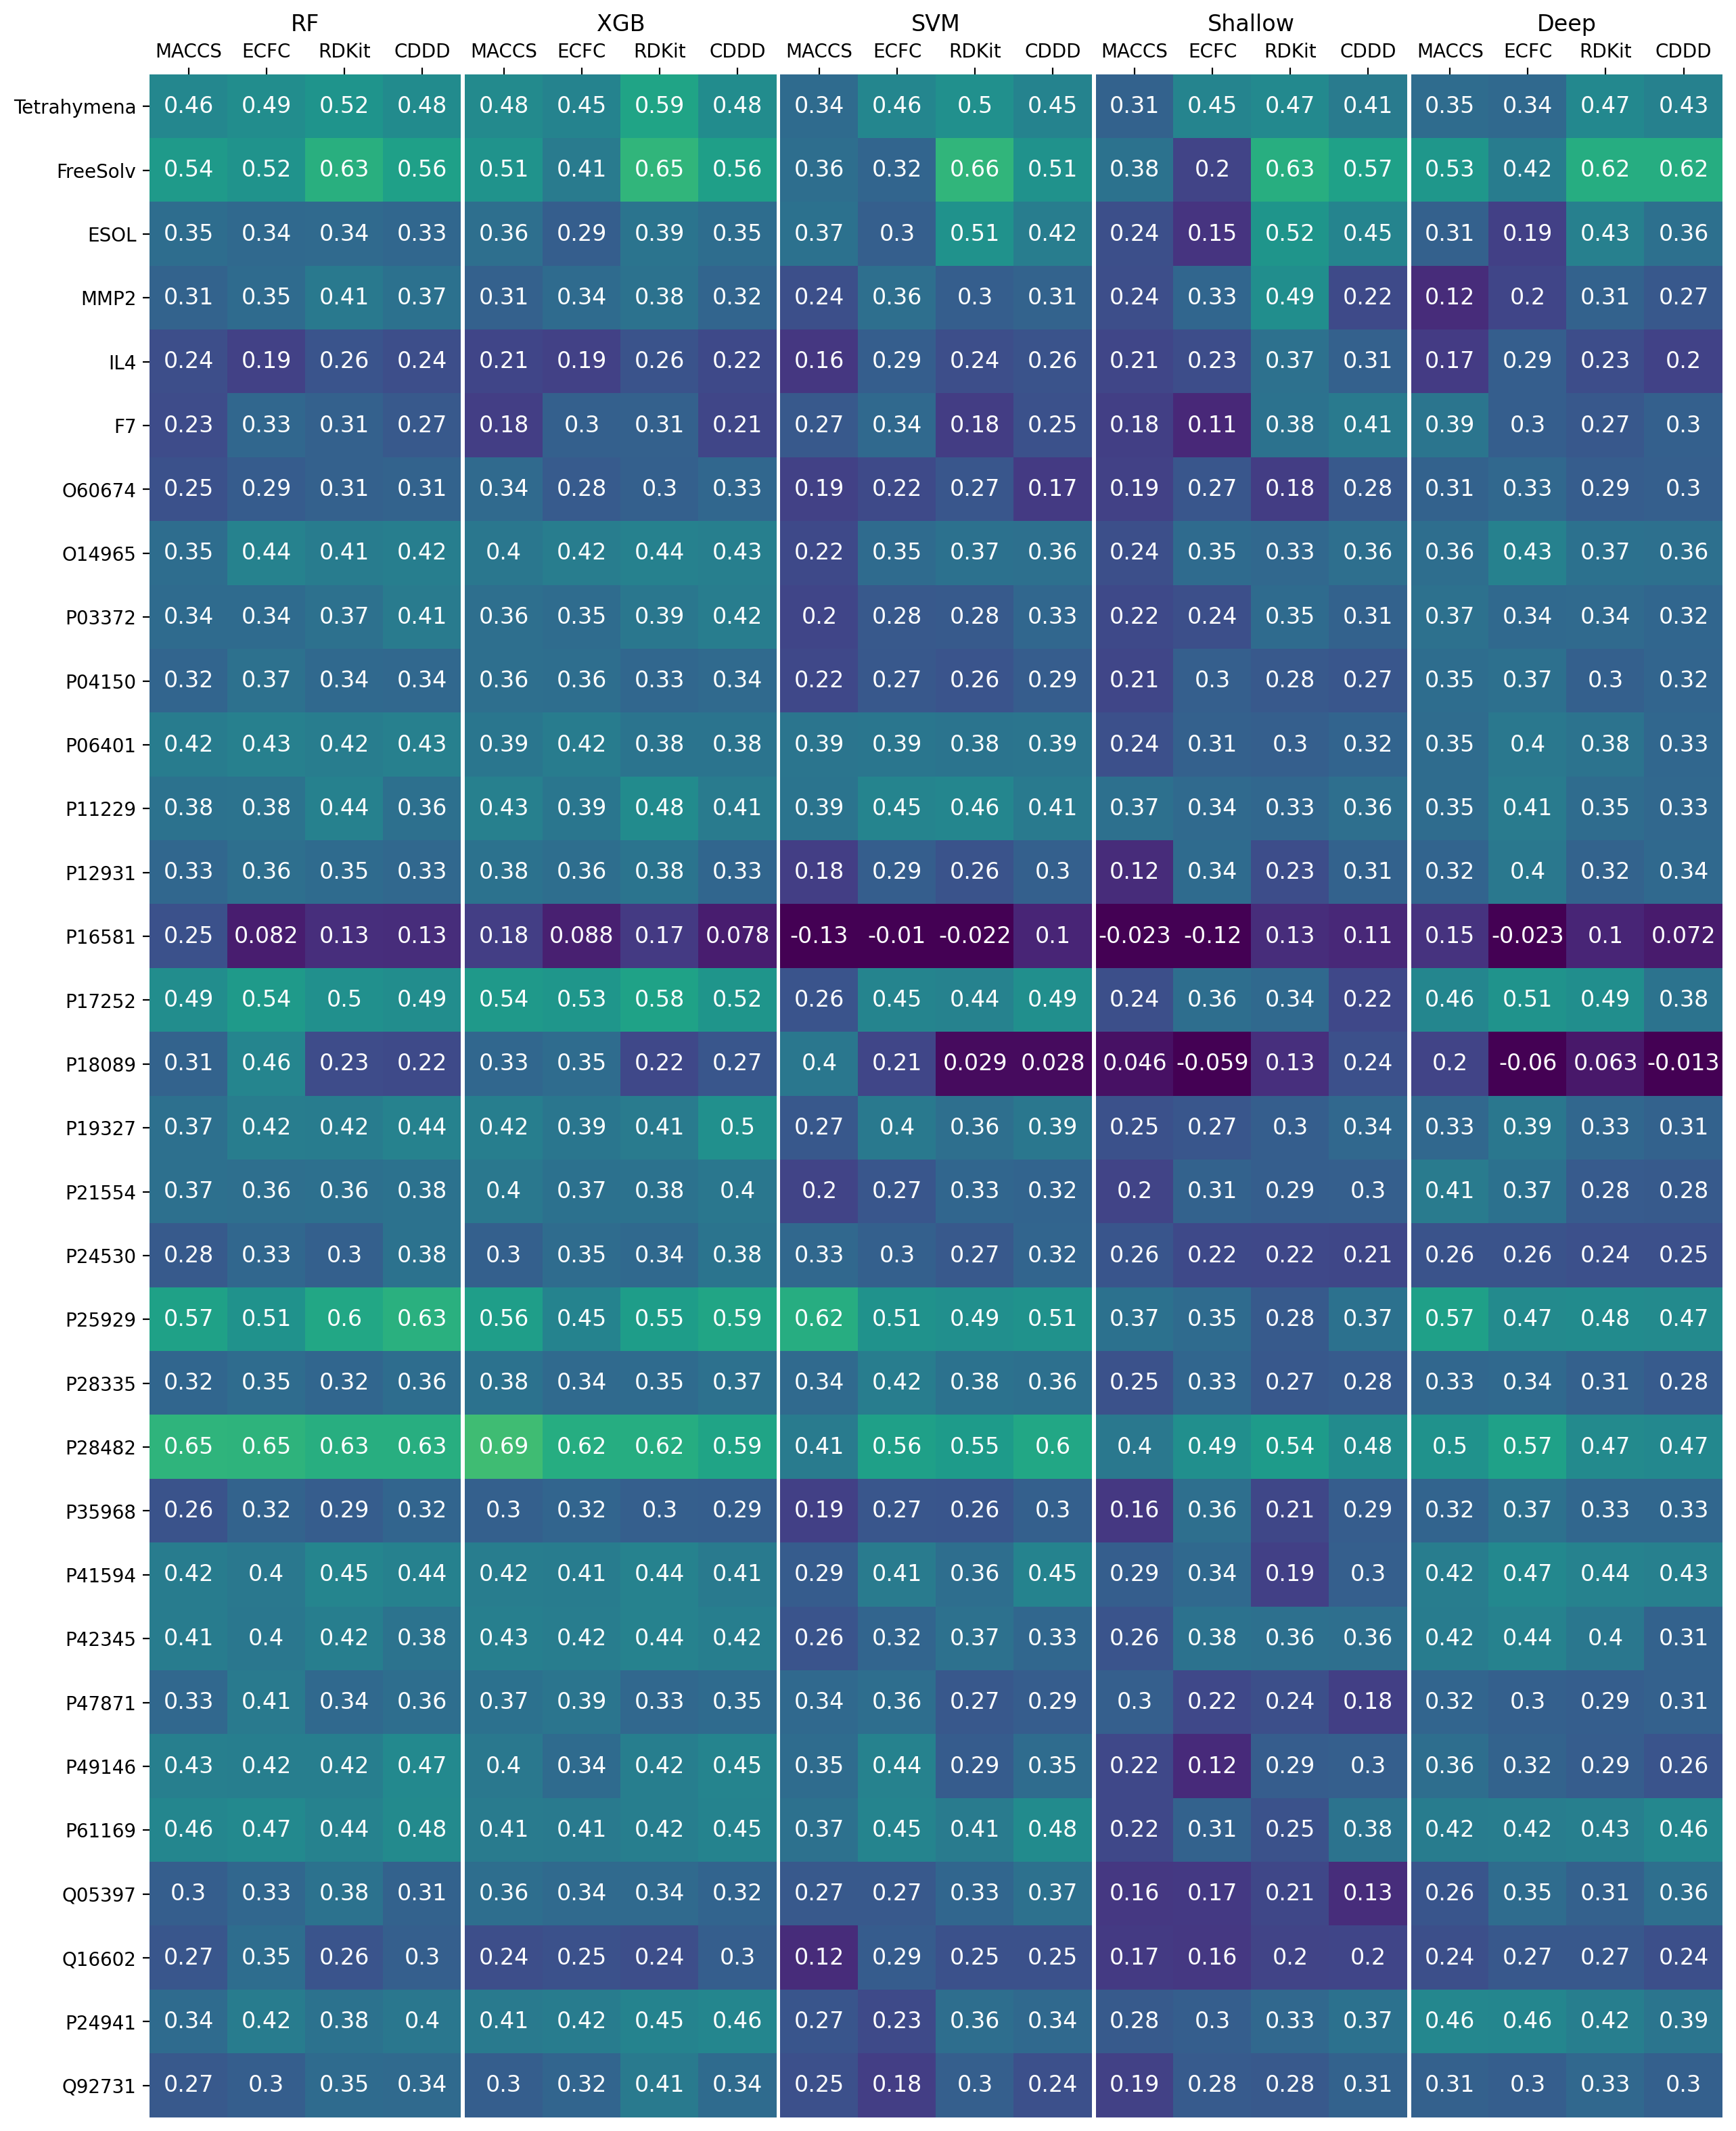

In [17]:
heatmap(uq_algorithm_wise_all_new_id, image_path='./plots/complete_heatmaps/uq_heat.pdf')

Find those datasets with biggest $\rho$ difference

In [18]:
(uq_algorithm_wise_all_new_id.max() - uq_algorithm_wise_all_new_id.abs().min()).sort_values(ascending=False).head()

freesolv    0.455359
P18089      0.442922
esol        0.372901
MMP2        0.367781
P17252      0.360904
dtype: float64